# HW5 – Fine-tuning a Pretrained CNN on Playing Card Ranks

In this assignment I train a convolutional neural network to classify the **rank** of playing cards (14 classes: 2–10, jack, queen, king, ace, plus joker) using the Kaggle “Cards Image Dataset.” I reorganize the original suit-level folders into 14 rank-level folders, then train a **pretrained ResNet-18** on the rank labels.

I use **5-fold stratified cross-validation** and a two-stage training strategy:
1. Train a small classifier head on frozen ResNet-18 features.
2. Fine-tune the full network end-to-end.

I report validation accuracy across the 5 folds and visualize both training behavior and convolutional feature maps for example face cards and number cards.


In [2]:
!pip install -q kaggle


In [3]:
import os, shutil, pathlib

# Your current path:
src = r"C:\Users\elean\OneDrive - University of Virginia\Documents\DS 3001\kaggle.json"

# Target folder Kaggle expects
dst_dir = pathlib.Path.home() / ".kaggle"
dst_dir.mkdir(exist_ok=True)
shutil.copy(src, dst_dir / "kaggle.json")

# Verify it's there
print("✅ Copied to:", dst_dir)


✅ Copied to: C:\Users\elean\.kaggle


In [4]:
os.chmod(dst_dir / "kaggle.json", 0o600)


In [5]:
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification -p ./data


Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0




  0%|          | 0.00/385M [00:00<?, ?B/s]
 22%|██▏       | 83.0M/385M [00:00<00:00, 848MB/s]
 45%|████▌     | 175M/385M [00:00<00:00, 898MB/s] 
 68%|██████▊   | 261M/385M [00:00<00:00, 761MB/s]
 87%|████████▋ | 336M/385M [00:00<00:00, 555MB/s]
100%|██████████| 385M/385M [00:00<00:00, 601MB/s]


In [6]:
import zipfile
from pathlib import Path

zip_path = Path("data/cards-image-datasetclassification.zip")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("data/cards")
print("✅ Dataset extracted to: data/cards")


✅ Dataset extracted to: data/cards


In [7]:
from pathlib import Path
root = Path("data/cards")
print("Subfolders:", [p.name for p in root.iterdir() if p.is_dir()])


Subfolders: ['test', 'train', 'valid']


In [ ]:
from pathlib import Path
for split in ["train", "valid", "test"]:
    path = Path(f"data/cards/{split}")
    print(split, ":", sorted([p.name for p in path.iterdir() if p.is_dir()]))

train : ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
valid : ['ace of clubs', 'ace of 

**Initial attempt at using k-fold validation**
(got a very low accuracy)

In [94]:
import os, shutil, re, json, math, random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.models as models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cpu")   # you said CUDA is False on your Dell
IMG_SIZE = 224
BATCH_SIZE = 32
N_WORKERS = 0   # Windows/Jupyter safe
K = 5


In [95]:
# Source with 53 classes (suits + ranks)
src_root = Path("data/cards")          # contains train/valid/test with folders like "eight of diamonds"
splits   = ["train", "valid", "test"]

# Destination with 14 rank classes
dst_root = Path("data/cards_rank14")
dst_root.mkdir(parents=True, exist_ok=True)

word_to_num = {
    "two":"2","three":"3","four":"4","five":"5","six":"6","seven":"7",
    "eight":"8","nine":"9","ten":"10"
}
valid_ranks = set(["ace","jack","queen","king","joker"] + list(word_to_num.values()))

def to_rank(class_name: str) -> str:
    rank = class_name.lower().split(" of ")[0].strip()
    return word_to_num.get(rank, rank)

moved = 0
for split in splits:
    src_split = src_root / split
    dst_split = dst_root / split
    dst_split.mkdir(parents=True, exist_ok=True)
    for card_class in sorted(p for p in src_split.iterdir() if p.is_dir()):
        rank = to_rank(card_class.name)
        if rank not in valid_ranks:
            print("Skipping:", card_class.name)
            continue
        (dst_split / rank).mkdir(exist_ok=True)
        for img in card_class.glob("*"):
            if img.is_file() and img.suffix.lower() in {".png",".jpg",".jpeg"}:
                shutil.copy2(img, dst_split / rank / img.name)
                moved += 1
print(f"Reorganized {moved} images into {dst_root}")


Reorganized 8154 images into data\cards_rank14


In [96]:
data_root = Path("data/cards_rank14")

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Slight but helpful augmentation for training
aug_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(0.15, 0.15, 0.10, 0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Build TRAIN first to define canonical class order
train_ds_full = datasets.ImageFolder(str(data_root/"train"), transform=aug_train)
classes = train_ds_full.classes
class_to_idx = {c:i for i,c in enumerate(classes)}
print("Canonical classes:", classes)

# helper: force val/test to use the same indices
def remap_split(root, tfm):
    tmp = datasets.ImageFolder(str(root), transform=tfm)
    remap = [class_to_idx[c] for c in tmp.classes]
    tt = (lambda idx: remap[idx])
    return datasets.ImageFolder(str(root), transform=tfm, target_transform=tt)

val_ds_full  = remap_split(data_root/"valid", eval_tfms)
test_ds_full = remap_split(data_root/"test",  eval_tfms)

def count_per_class(ds):
    c = Counter([t for _, t in ds.samples])
    return {classes[i]: c.get(i,0) for i in range(len(classes))}

print("Train counts:", count_per_class(train_ds_full))
print("Val counts:  ", count_per_class(val_ds_full))
print("Test counts: ", count_per_class(test_ds_full))


Canonical classes: ['10', '2', '3', '4', '5', '6', '7', '8', '9', 'ace', 'jack', 'joker', 'king', 'queen']
Train counts: {'10': 158, '2': 155, '3': 153, '4': 157, '5': 158, '6': 158, '7': 165, '8': 159, '9': 154, 'ace': 181, 'jack': 172, 'joker': 115, 'king': 151, 'queen': 163}
Val counts:   {'10': 5, '2': 5, '3': 5, '4': 5, '5': 5, '6': 5, '7': 5, '8': 5, '9': 5, 'ace': 5, 'jack': 5, 'joker': 5, 'king': 5, 'queen': 5}
Test counts:  {'10': 5, '2': 5, '3': 5, '4': 5, '5': 5, '6': 5, '7': 5, '8': 5, '9': 5, 'ace': 5, 'jack': 5, 'joker': 5, 'king': 5, 'queen': 5}


In [97]:
# Make arrays of indices/labels for train_ds_full
train_indices = np.arange(len(train_ds_full))
train_labels  = np.array([y for _, y in train_ds_full.samples])

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
folds = list(skf.split(train_indices, train_labels))

print(f"{K}-fold splits ready (on the TRAIN split only).")


5-fold splits ready (on the TRAIN split only).


In [98]:
# Pretrained ResNet-18 as frozen feature extractor
weights = models.ResNet18_Weights.DEFAULT
backbone = models.resnet18(weights=weights)
feat_dim = backbone.fc.in_features  # 512
backbone.fc = nn.Identity()
for p in backbone.parameters():
    p.requires_grad = False
backbone = backbone.to(device)

@torch.no_grad()
def extract_features(dataset, indices):
    """Return features and labels as tensors for a subset of dataset."""
    loader = DataLoader(Subset(dataset, indices),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)
    feats, labs = [], []
    backbone.eval()
    for xb, yb in loader:
        xb = xb.to(device)
        z  = backbone(xb).cpu()
        feats.append(z)
        labs.append(yb)
    return torch.cat(feats), torch.cat(labs)


In [99]:
def train_head(Xtr, ytr, Xva, yva, epochs=25, lr=2e-3, wd=1e-4, bs=256):
    head = nn.Sequential(
        nn.Linear(feat_dim, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, len(classes))
    ).to(device)
    opt = optim.AdamW(head.parameters(), lr=lr, weight_decay=wd)

    def run_epoch(X, y, train=True):
        head.train(train)
        total=correct=0; loss_sum=0.0
        for i in range(0, X.size(0), bs):
            xb = X[i:i+bs].to(device); yb = y[i:i+bs].to(device)
            logits = head(xb)
            loss = F.cross_entropy(logits, yb, label_smoothing=0.05)
            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(head.parameters(), 5.0)
                opt.step()
            loss_sum += loss.item()*xb.size(0)
            correct  += (logits.argmax(1)==yb).sum().item()
            total    += xb.size(0)
        return loss_sum/total, correct/total

    best_val=float("inf"); best_state=None; patience=6; left=6
    history = {"trL":[], "trA":[], "vaL":[], "vaA":[]}

    for ep in range(1, epochs+1):
        trL,trA = run_epoch(Xtr, ytr, True)
        vaL,vaA = run_epoch(Xva, yva, False)
        history["trL"].append(trL); history["trA"].append(trA)
        history["vaL"].append(vaL); history["vaA"].append(vaA)
        print(f"ep {ep:02d} | train {trL:.4f}/{trA:.3f} | val {vaL:.4f}/{vaA:.3f}")
        if vaL < best_val - 1e-4:
            best_val, best_state, left = vaL, head.state_dict(), patience
        else:
            left -= 1
            if left == 0:
                print("early stop"); break
    if best_state: head.load_state_dict(best_state)
    return head, history


In [100]:
fold_metrics = []
all_histories = []

for fold_id, (tr_idx, va_idx) in enumerate(folds, start=1):
    print(f"\n=== Fold {fold_id}/{K} ===")
    # Use current transforms; for best fairness, reapply aug to train subset (ok for bottleneck)
    Xtr, ytr = extract_features(train_ds_full, tr_idx)
    # eval transforms are already on train_ds_full; but augmentation randomness won’t affect features here.
    Xva, yva = extract_features(train_ds_full, va_idx)

    head, history = train_head(Xtr, ytr, Xva, yva, epochs=30)
    # final fold metrics
    with torch.no_grad():
        logits = head(Xva.to(device)).cpu()
        va_loss = F.cross_entropy(logits, yva).item()
        va_acc  = (logits.argmax(1)==yva).float().mean().item()
    print(f"[Fold {fold_id}] val loss {va_loss:.4f} | val acc {va_acc:.3f}")
    fold_metrics.append(va_acc)
    all_histories.append(history)

print("\nCV accuracies:", [f"{a:.3f}" for a in fold_metrics])
print("CV mean acc:", f"{np.mean(fold_metrics):.3f}", "| std:", f"{np.std(fold_metrics):.3f}")



=== Fold 1/5 ===
ep 01 | train 3.8064/0.016 | val 2.6670/0.093
ep 02 | train 2.6091/0.098 | val 2.5775/0.180
ep 03 | train 2.5858/0.134 | val 2.5377/0.250
ep 04 | train 2.5406/0.180 | val 2.4796/0.264
ep 05 | train 2.4874/0.210 | val 2.4165/0.311
ep 06 | train 2.4092/0.252 | val 2.3470/0.323
ep 07 | train 2.3553/0.260 | val 2.2788/0.366
ep 08 | train 2.2938/0.271 | val 2.2126/0.393
ep 09 | train 2.2158/0.301 | val 2.1503/0.400
ep 10 | train 2.1533/0.310 | val 2.0927/0.393
ep 11 | train 2.1113/0.316 | val 2.0435/0.416
ep 12 | train 2.0615/0.327 | val 2.0044/0.432
ep 13 | train 2.0275/0.325 | val 1.9710/0.432
ep 14 | train 1.9863/0.358 | val 1.9404/0.434
ep 15 | train 1.9569/0.370 | val 1.9119/0.448
ep 16 | train 1.9305/0.379 | val 1.8877/0.455
ep 17 | train 1.8982/0.371 | val 1.8675/0.457
ep 18 | train 1.8833/0.396 | val 1.8464/0.455
ep 19 | train 1.8400/0.430 | val 1.8280/0.445
ep 20 | train 1.8399/0.413 | val 1.8076/0.473
ep 21 | train 1.8042/0.426 | val 1.7898/0.468
ep 22 | train 1.

Realized that the accuracy was too low so started data augmentation and retraining in order to try to achieve a higher accuracy. 

**Second attempts at running a k-fold validation** 
- better results then the first one
- included data augmentation
- accuracy was nearly 90%, but slightly lower (87% average +- 0.02)

In [ ]:
#cell 1

import os, random, math, glob
from pathlib import Path
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.models as models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cpu")  # CPU-only notebook
print("Device:", device)


Device: cpu


In [83]:
from pathlib import Path

IMG_EXTS = {".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG"}

def count_images(root: Path):
    return sum(1 for p in root.rglob("*") if p.suffix in IMG_EXTS)

print("Tree under data/:")
for p in sorted(Path("data").glob("**/"), key=lambda x: (len(x.parts), str(x))):
    if p.is_dir() and ("cards" in str(p).lower()):
        kids = [k.name for k in p.iterdir() if k.is_dir()]
        print(f"• {p} -> {kids[:10]}{' ... (+ more)' if len(kids)>10 else ''} | imgs: {count_images(p)}")

print("Total images under data/:", count_images(Path("data")))


Tree under data/:
• data\cards -> ['test', 'train', 'valid'] | imgs: 8154
• data\cards_rank14 -> ['test', 'train', 'valid'] | imgs: 2339
• data\cards\test -> ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds'] ... (+ more) | imgs: 265
• data\cards\train -> ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds'] ... (+ more) | imgs: 7624
• data\cards\valid -> ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds'] ... (+ more) | imgs: 265
• data\cards_rank14\test -> ['10', '2', '3', '4', '5', '6', '7', '8', '9', 'ace'] ... (+ more) | imgs: 70
• data\cards_rank14\train -> ['10', '2', '3', '4', '5', '6', '7'

In [84]:
# ========================================
# Cell 2 — Robust path detection & file list (jpg/jpeg/png)
# ========================================
from pathlib import Path
from torchvision import datasets
import numpy as np

IMG_EXTS = {".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG"}

candidates = [
    Path("data/cards_rank14"),
    Path("data/cards_rank14/train"),
    Path("data/cards_rank14/valid"),
    Path("data/cards_rank14/test"),
    Path("data/cards/train"),
    Path("data/cards/valid"),
    Path("data/cards/test"),
]

def guess_rank_root():
    # pick the directory that contains 14 subfolders (the ranks)
    for cand in candidates:
        if cand.exists():
            subs = [p for p in cand.iterdir() if p.is_dir()]
            if len(subs) == 14:
                return cand
    for cand in candidates:
        if cand.exists():
            return cand
    return None

rank_root = guess_rank_root()
if rank_root is None:
    raise RuntimeError("Could not find a directory with rank folders. Check your data/ layout.")

print("Rank root guessed as:", rank_root.resolve())

# If rank_root is a split dir (train/valid/test exist), aggregate across all three
base = rank_root.parent
if base.joinpath("train").exists() and base.joinpath("valid").exists() and base.joinpath("test").exists():
    split_dirs = [base/"train", base/"valid", base/"test"]
else:
    split_dirs = [rank_root]

# Build class list from the first split dir
tmp_ds = datasets.ImageFolder(str(split_dirs[0]))
rank_classes = tmp_ds.classes
print("Classes:", rank_classes, "| n_classes:", len(rank_classes))

# Aggregate files across splits (jpg/jpeg/png)
all_files, all_targets = [], []
for split_dir in split_dirs:
    for cls_idx, cls_name in enumerate(rank_classes):
        cls_dir = split_dir / cls_name
        if not cls_dir.exists():
            continue
        for p in cls_dir.iterdir():
            if p.is_file() and p.suffix in IMG_EXTS:
                all_files.append(str(p))
                all_targets.append(cls_idx)

all_files   = np.array(all_files)
all_targets = np.array(all_targets)
print("Total images collected across splits:", len(all_files))

if len(all_files) == 0:
    raise RuntimeError("No images found. Your folders may contain only JPG/JPEG; this cell already handles those. If still zero, check the paths printed above.")


Rank root guessed as: C:\Users\elean\OneDrive - University of Virginia\Documents\DS 3001\data\cards_rank14\train
Classes: ['10', '2', '3', '4', '5', '6', '7', '8', '9', 'ace', 'jack', 'joker', 'king', 'queen'] | n_classes: 14
Total images collected across splits: 2339


In [88]:
#cell 3

IMG_SIZE = 256   # 224..256 is OK on CPU; 256 gives a bit more corner detail
BATCH    = 32

weights = models.ResNet18_Weights.DEFAULT
# Use the exact mean/std that these weights expect
mean, std = weights.transforms().mean, weights.transforms().std

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),           # keep full card (no center crop)
    transforms.RandomRotation(2),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.15, 0.15, 0.10, 0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.15, scale=(0.02, 0.08))
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


## Data loading and augmentation

Here I load the images from the Kaggle train, validation, and test splits and regroup them by **rank** instead of full “rank of suit” names. I apply standard ImageNet normalization for ResNet-18 and light data augmentation on the training split:

- Resize to 224×224 so the whole card is visible.
- Random horizontal flip so the model does not overfit to one orientation.
- Color jitter to make the model robust to small lighting and color shifts.

For validation and test I only resize and normalize, without any augmentation.


In [89]:
# cell 4

class FileListDataset(torch.utils.data.Dataset):
    def __init__(self, files, targets, transform):
        self.files = files
        self.targets = targets
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        x = Image.open(self.files[i]).convert("RGB")
        y = int(self.targets[i])
        return self.transform(x), y


In [90]:
# cell 5

# Pretrained backbone: ResNet18
backbone = models.resnet18(weights=weights).to(device)
feat_dim = backbone.fc.in_features
# Make backbone produce features (not logits) for stage 1
backbone.fc = nn.Identity()
for p in backbone.parameters():
    p.requires_grad = False
backbone.eval()
print("Feature dim:", feat_dim)

# Head for bottleneck stage
def make_head():
    return nn.Sequential(
        nn.Linear(feat_dim, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, len(rank_classes))
    ).to(device)



Feature dim: 512


In [91]:
#cell 6

@torch.no_grad()
def extract_features(files, targets, model, tfm):
    ds = FileListDataset(files, targets, tfm)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=0)
    feats, labels = [], []
    for xb, yb in dl:
        xb = xb.to(device)
        z  = model(xb).cpu()
        feats.append(z)
        labels.append(yb)
    return torch.cat(feats), torch.cat(labels)

def run_head_epoch(X, y, model, opt=None):
    model.train(mode=(opt is not None))
    total, correct, loss_sum = 0, 0, 0.0
    for i in range(0, X.size(0), BATCH):
        xb = X[i:i+BATCH].to(device)
        yb = y[i:i+BATCH].to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb, label_smoothing=0.05)
        if opt is not None:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
        loss_sum += loss.item() * xb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        total    += xb.size(0)
    return loss_sum/total, correct/total

def run_backbone_epoch(model, dl, opt=None):
    model.train(mode=(opt is not None))
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb, label_smoothing=0.05)
        if opt is not None:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
        loss_sum += loss.item() * xb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        total    += xb.size(0)
    return loss_sum/total, correct/total

def show_confusion(y_true, y_pred, classes, title="Confusion"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.colorbar()
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks(range(len(classes)), classes)
    plt.tight_layout(); plt.show()


## Model and 5-fold training strategy

I use **ResNet-18 pretrained on ImageNet** as the backbone. First I turn the final fully connected layer into an identity layer and freeze all weights. I then train a small multilayer perceptron head on top of the frozen 512-dimensional features. This is a bottleneck-style stage that quickly finds a good linear separator for the 14 ranks.

Next, for each fold, I unfreeze the backbone and run a short fine-tuning stage (“FT”) where I optimize all parameters with a smaller learning rate. This improves validation accuracy by adapting the convolutional filters from generic ImageNet features to the specific structure of playing card images.

I perform this two-stage training inside a **StratifiedKFold (k = 5)** loop, so every image in the training split appears once as validation and four times as training. At the end I compute the mean and standard deviation of validation accuracy across the 5 folds.



=== Fold 1/5 ===
[Head] ep 01 | train 3.8832/0.056 | val 2.6391/0.077
[Head] ep 02 | train 2.6621/0.043 | val 2.6494/0.075
[Head] ep 03 | train 2.6775/0.078 | val 2.6389/0.077
[Head] ep 04 | train 2.6480/0.078 | val 2.6386/0.077
[Head] ep 05 | train 2.6475/0.078 | val 2.6384/0.077
[Head] ep 06 | train 2.6471/0.078 | val 2.6382/0.077
[Head] ep 07 | train 2.6468/0.078 | val 2.6381/0.077
[Head] ep 08 | train 2.6466/0.078 | val 2.6379/0.077
[Head] ep 09 | train 2.6463/0.078 | val 2.6378/0.077
[Head] ep 10 | train 2.6461/0.078 | val 2.6376/0.077
[Head] ep 11 | train 2.6460/0.078 | val 2.6375/0.077
[Head] ep 12 | train 2.6458/0.078 | val 2.6374/0.077
[Head] ep 13 | train 2.6457/0.078 | val 2.6373/0.077
[Head] ep 14 | train 2.6455/0.078 | val 2.6372/0.077
[Head] ep 15 | train 2.6454/0.078 | val 2.6371/0.077
[Head] ep 16 | train 2.6453/0.078 | val 2.6371/0.077
[Head] ep 17 | train 2.6452/0.078 | val 2.6370/0.077
[Head] ep 18 | train 2.6451/0.021 | val 2.6369/0.077
[Head] ep 19 | train 2.6451/

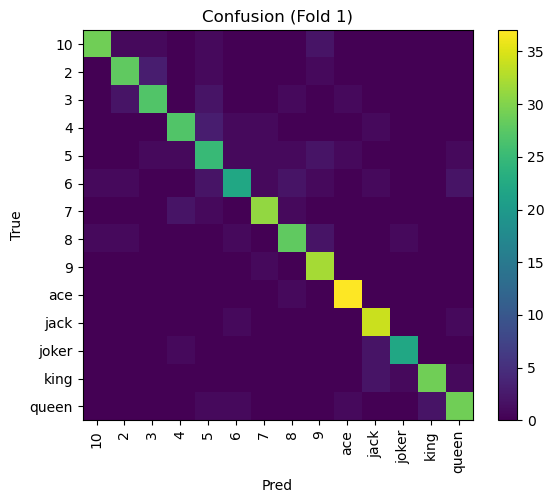


=== Fold 2/5 ===
[Head] ep 01 | train 3.5152/0.058 | val 2.6896/0.071
[Head] ep 02 | train 2.7569/0.005 | val 2.6395/0.071
[Head] ep 03 | train 2.6501/0.004 | val 2.6393/0.071
[Head] ep 04 | train 2.6486/0.004 | val 2.6390/0.071
[Head] ep 05 | train 2.6479/0.004 | val 2.6388/0.071
[Head] ep 06 | train 2.6474/0.004 | val 2.6386/0.071
[Head] ep 07 | train 2.6471/0.004 | val 2.6384/0.071
[Head] ep 08 | train 2.6468/0.005 | val 2.6382/0.081
[Head] ep 09 | train 2.6466/0.005 | val 2.6380/0.081
[Head] ep 10 | train 2.6463/0.005 | val 2.6379/0.081
[Head] ep 11 | train 2.6462/0.005 | val 2.6378/0.081
[Head] ep 12 | train 2.6460/0.005 | val 2.6376/0.081
[Head] ep 13 | train 2.6458/0.005 | val 2.6375/0.081
[Head] ep 14 | train 2.6457/0.036 | val 2.6374/0.081
[Head] ep 15 | train 2.6456/0.082 | val 2.6373/0.081
[Head] ep 16 | train 2.6455/0.082 | val 2.6372/0.081
[Head] ep 17 | train 2.6454/0.082 | val 2.6371/0.081
[Head] ep 18 | train 2.6453/0.082 | val 2.6371/0.081
[Head] ep 19 | train 2.6452/

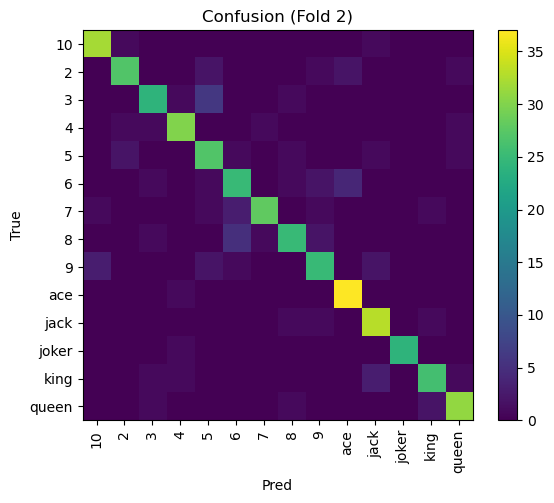


=== Fold 3/5 ===
[Head] ep 01 | train 3.7637/0.057 | val 2.6861/0.053
[Head] ep 02 | train 2.6946/0.004 | val 2.6387/0.075
[Head] ep 03 | train 2.6486/0.004 | val 2.6385/0.075
[Head] ep 04 | train 2.6477/0.004 | val 2.6383/0.075
[Head] ep 05 | train 2.6472/0.015 | val 2.6381/0.083
[Head] ep 06 | train 2.6469/0.015 | val 2.6379/0.083
[Head] ep 07 | train 2.6466/0.004 | val 2.6378/0.083
[Head] ep 08 | train 2.6464/0.004 | val 2.6377/0.083
[Head] ep 09 | train 2.6462/0.004 | val 2.6375/0.083
[Head] ep 10 | train 2.6460/0.004 | val 2.6374/0.083
[Head] ep 11 | train 2.6459/0.004 | val 2.6373/0.083
[Head] ep 12 | train 2.6458/0.021 | val 2.6372/0.083
[Head] ep 13 | train 2.6456/0.081 | val 2.6371/0.083
[Head] ep 14 | train 2.6455/0.081 | val 2.6370/0.083
[Head] ep 15 | train 2.6454/0.081 | val 2.6369/0.083
[Head] ep 16 | train 2.6453/0.081 | val 2.6369/0.083
[Head] ep 17 | train 2.6453/0.081 | val 2.6368/0.083
[Head] ep 18 | train 2.6452/0.081 | val 2.6367/0.083
[Head] ep 19 | train 2.6451/

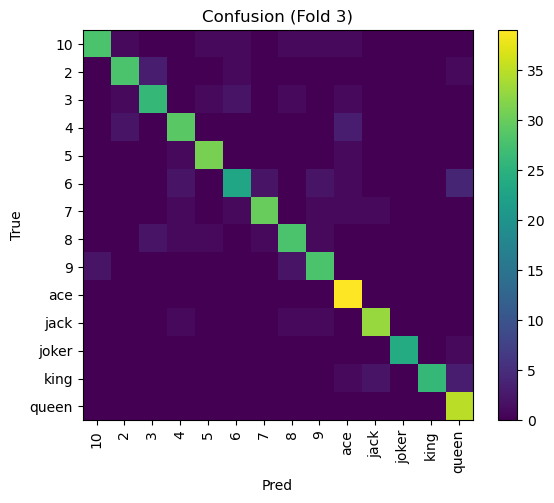


=== Fold 4/5 ===
[Head] ep 01 | train 3.9067/0.060 | val 2.6393/0.071
[Head] ep 02 | train 2.6925/0.005 | val 2.6391/0.071
[Head] ep 03 | train 2.6484/0.005 | val 2.6389/0.071
[Head] ep 04 | train 2.6476/0.004 | val 2.6387/0.081
[Head] ep 05 | train 2.6471/0.004 | val 2.6385/0.081
[Head] ep 06 | train 2.6468/0.004 | val 2.6383/0.081
[Head] ep 07 | train 2.6465/0.004 | val 2.6381/0.081
[Head] ep 08 | train 2.6463/0.035 | val 2.6379/0.081
[Head] ep 09 | train 2.6461/0.082 | val 2.6378/0.081
[Head] ep 10 | train 2.6459/0.082 | val 2.6376/0.081
[Head] ep 11 | train 2.6458/0.082 | val 2.6375/0.081
[Head] ep 12 | train 2.6457/0.082 | val 2.6374/0.081
[Head] ep 13 | train 2.6455/0.082 | val 2.6373/0.081
[Head] ep 14 | train 2.6454/0.082 | val 2.6372/0.081
[Head] ep 15 | train 2.6453/0.082 | val 2.6371/0.081
[Head] ep 16 | train 2.6452/0.082 | val 2.6370/0.081
[Head] ep 17 | train 2.6451/0.082 | val 2.6369/0.081
[Head] ep 18 | train 2.6450/0.082 | val 2.6369/0.081
[Head] ep 19 | train 2.6450/

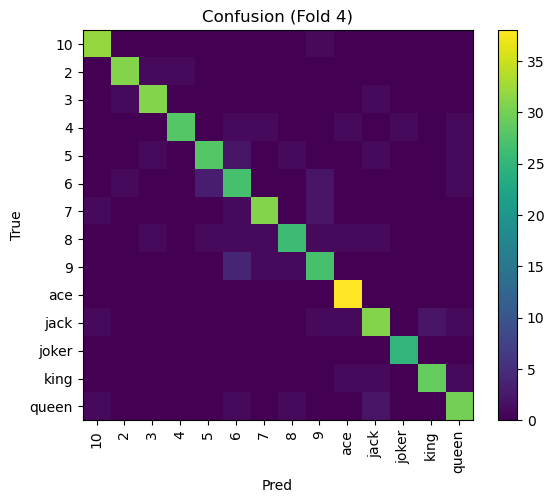


=== Fold 5/5 ===
[Head] ep 01 | train 3.5715/0.061 | val 2.6344/0.079
[Head] ep 02 | train 2.6204/0.086 | val 2.7533/0.073
[Head] ep 03 | train 2.7329/0.033 | val 2.6382/0.079
[Head] ep 04 | train 2.6477/0.077 | val 2.6380/0.079
[Head] ep 05 | train 2.6471/0.077 | val 2.6379/0.079
[Head] ep 06 | train 2.6468/0.077 | val 2.6377/0.079
[Head] ep 07 | train 2.6465/0.077 | val 2.6376/0.079
  early stop (head)
[Fold 5] Stage1 val acc: 0.079
[FT]   ep 01 | train 1.5422/0.542 | val 0.9517/0.771
[FT]   ep 02 | train 0.7368/0.872 | val 0.8130/0.835
[FT]   ep 03 | train 0.5164/0.951 | val 0.7445/0.859
[FT]   ep 04 | train 0.4298/0.982 | val 0.7451/0.857
[FT]   ep 05 | train 0.3925/0.992 | val 0.7156/0.876
[FT]   ep 06 | train 0.3768/0.996 | val 0.6910/0.889
[FT]   ep 07 | train 0.3616/0.997 | val 0.6879/0.895
[FT]   ep 08 | train 0.3568/0.999 | val 0.6758/0.897
[Fold 5] FINAL val acc: 0.897


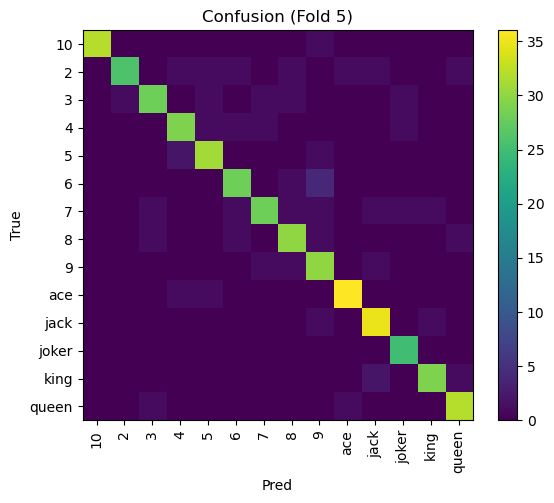


=== 5-Fold Summary ===
Per-fold acc: ['0.855', '0.842', '0.872', '0.885', '0.897']
Mean acc: 0.870 ± 0.020


In [ ]:
# 
K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

fold_metrics = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(all_files, all_targets), start=1):
    print(f"\n=== Fold {fold}/{K} ===")
    tr_files, va_files = all_files[tr_idx], all_files[va_idx]
    tr_tgts,  va_tgts  = all_targets[tr_idx], all_targets[va_idx]

    # --- Stage 1: bottleneck (head only) ---
    # Extract features from frozen backbone
    X_tr, y_tr = extract_features(tr_files, tr_tgts, backbone, train_tfms)
    X_va, y_va = extract_features(va_files, va_tgts, backbone, eval_tfms)

    head = make_head()
    opt_head = torch.optim.AdamW(head.parameters(), lr=2e-3, weight_decay=1e-4)

    best_val, best_state, patience, left = float("inf"), None, 6, 6
    EPOCHS1 = 20
    for ep in range(1, EPOCHS1+1):
        trL, trA = run_head_epoch(X_tr, y_tr, head, opt_head)
        vaL, vaA = run_head_epoch(X_va, y_va, head, None)
        print(f"[Head] ep {ep:02d} | train {trL:.4f}/{trA:.3f} | val {vaL:.4f}/{vaA:.3f}")
        if vaL < best_val - 1e-4:
            best_val, best_state, left = vaL, head.state_dict(), patience
        else:
            left -= 1
            if left == 0:
                print("  early stop (head)")
                break
    if best_state: head.load_state_dict(best_state)

    # Quick val accuracy snapshot (stage 1)
    with torch.no_grad():
        logits = head(X_va.to(device)).cpu()
    va_acc_stage1 = (logits.argmax(1) == y_va).float().mean().item()
    print(f"[Fold {fold}] Stage1 val acc: {va_acc_stage1:.3f}")

    # --- Stage 2: fine-tune layer4 + fc end-to-end ---
    ft_model = models.resnet18(weights=weights).to(device)
    # freeze all
    for p in ft_model.parameters():
        p.requires_grad = False
    # unfreeze layer4 + replace fc
    for p in ft_model.layer4.parameters():
        p.requires_grad = True
    ft_model.fc = nn.Linear(ft_model.fc.in_features, len(rank_classes)).to(device)

    # init fc from trained head's last layer (helps convergence)
    with torch.no_grad():
        last_linear = [m for m in head if isinstance(m, nn.Linear)][-1]
        if last_linear.weight.shape == ft_model.fc.weight.shape:
            ft_model.fc.weight.copy_(last_linear.weight)
            ft_model.fc.bias.copy_(last_linear.bias)

    # Build fold loaders with on-the-fly transforms
    tr_ds = FileListDataset(tr_files, tr_tgts, train_tfms)
    va_ds = FileListDataset(va_files, va_tgts, eval_tfms)
    tr_dl = DataLoader(tr_ds, batch_size=BATCH, shuffle=True,  num_workers=0)
    va_dl = DataLoader(va_ds, batch_size=BATCH, shuffle=False, num_workers=0)

    opt_ft = torch.optim.AdamW(filter(lambda p: p.requires_grad, ft_model.parameters()),
                               lr=3e-4, weight_decay=3e-4)
    sch_ft = torch.optim.lr_scheduler.CosineAnnealingLR(opt_ft, T_max=8)
    best_ft, best_ft_state, left = float("inf"), None, 5
    EPOCHS2 = 8

    for ep in range(1, EPOCHS2+1):
        trL, trA = run_backbone_epoch(ft_model, tr_dl, opt_ft)
        vaL, vaA = run_backbone_epoch(ft_model, va_dl, None)
        sch_ft.step()
        print(f"[FT]   ep {ep:02d} | train {trL:.4f}/{trA:.3f} | val {vaL:.4f}/{vaA:.3f}")
        if vaL < best_ft - 1e-4:
            best_ft, best_ft_state, left = vaL, {k:v.cpu() for k,v in ft_model.state_dict().items()}, 5
        else:
            left -= 1
            if left == 0:
                print("  early stop (ft)")
                break
    if best_ft_state:
        ft_model.load_state_dict({k:v.to(device) for k,v in best_ft_state.items()})

    # Final fold val metrics
    ft_model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in va_dl:
            xb = xb.to(device)
            logits = ft_model(xb).cpu()
            y_pred.append(logits.argmax(1))
            y_true.append(yb)
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    acc = (y_true == y_pred).mean()
    print(f"[Fold {fold}] FINAL val acc: {acc:.3f}")

    show_confusion(y_true, y_pred, rank_classes, title=f"Confusion (Fold {fold})")
    fold_metrics.append(acc)

print("\n=== 5-Fold Summary ===")
print("Per-fold acc:", [f"{a:.3f}" for a in fold_metrics])
print("Mean acc:", f"{np.mean(fold_metrics):.3f}", "±", f"{np.std(fold_metrics):.3f}")


## Feature map visualizations: face vs number cards

To understand what the fine-tuned network has learned, I visualize intermediate feature maps for several example images. I select at least **two face-card ranks** (for example queen and king) and **two number-card ranks** (for example five and ten). For each image I hook into an early convolutional layer and a deeper layer:

- Early layer (e.g. `layer1[0].conv1`) tends to highlight simple edges and card borders.
- Deeper layer (e.g. `layer3[0].conv1`) focuses on higher-level patterns, such as the arrangement of suit symbols and the structure of the rank glyphs.

These visualizations show that the model learns to emphasize the regions where the rank is printed and the clusters of suit icons that distinguish different ranks.


Examples: ['data\\cards_rank14\\valid\\king\\1.jpg', 'data\\cards_rank14\\valid\\queen\\1.jpg', 'data\\cards_rank14\\valid\\8\\1.jpg', 'data\\cards_rank14\\valid\\5\\1.jpg']


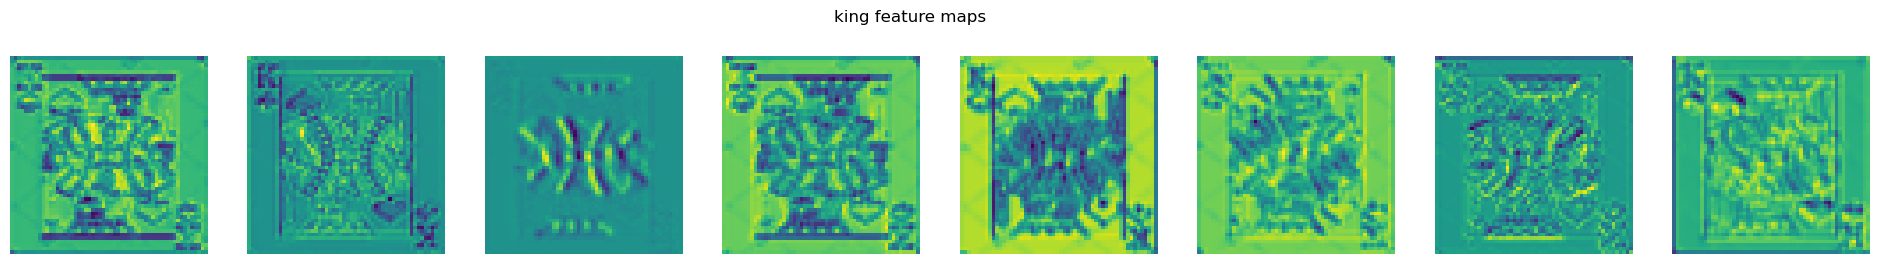

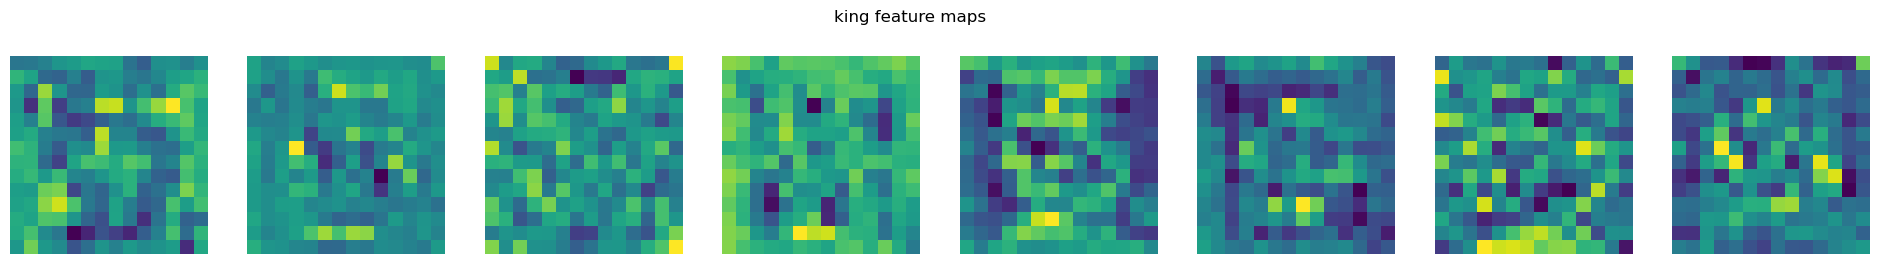

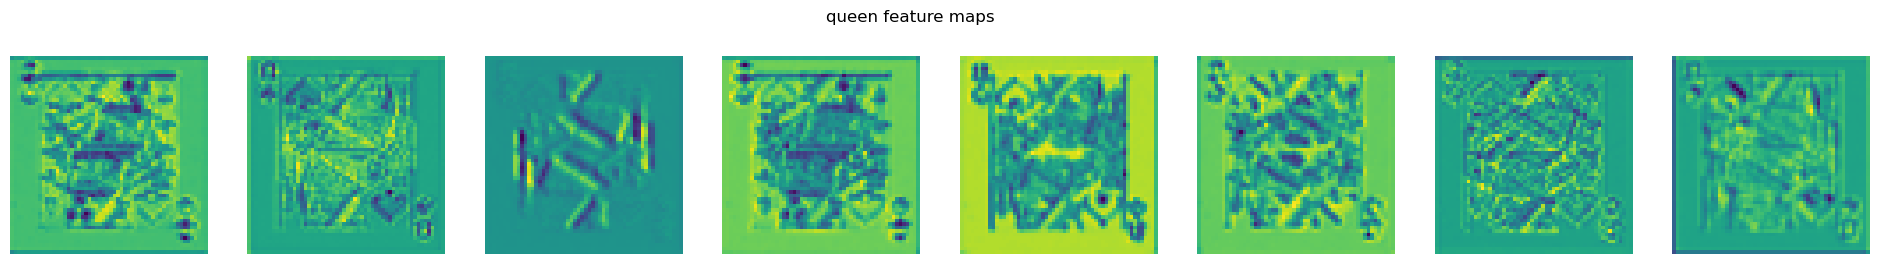

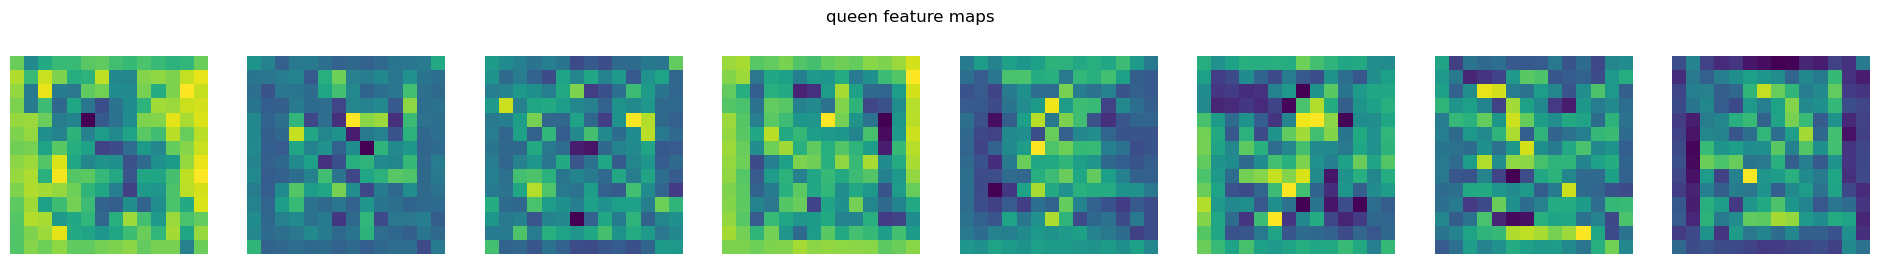

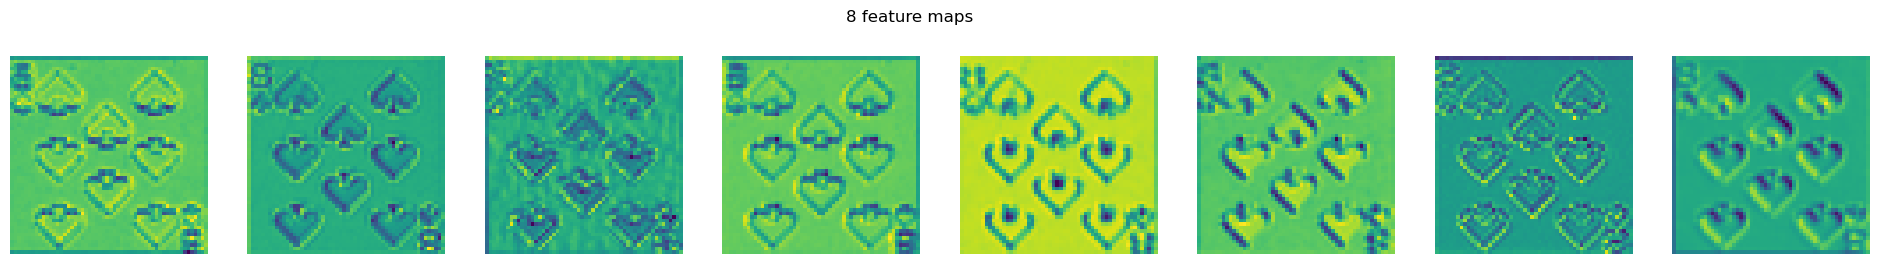

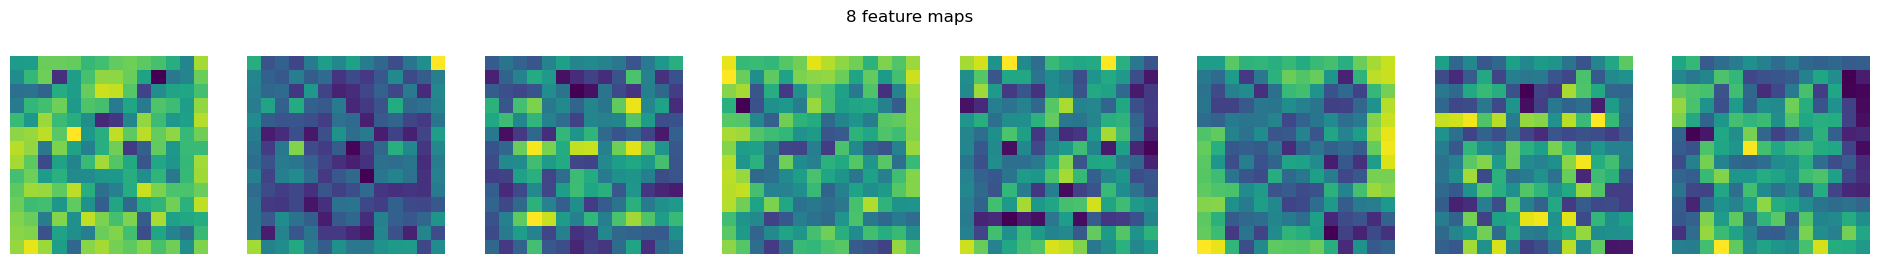

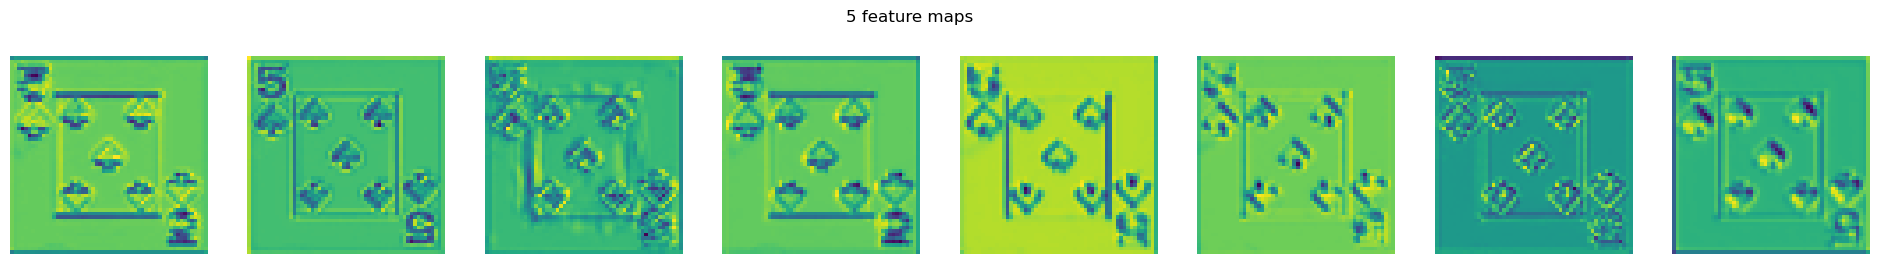

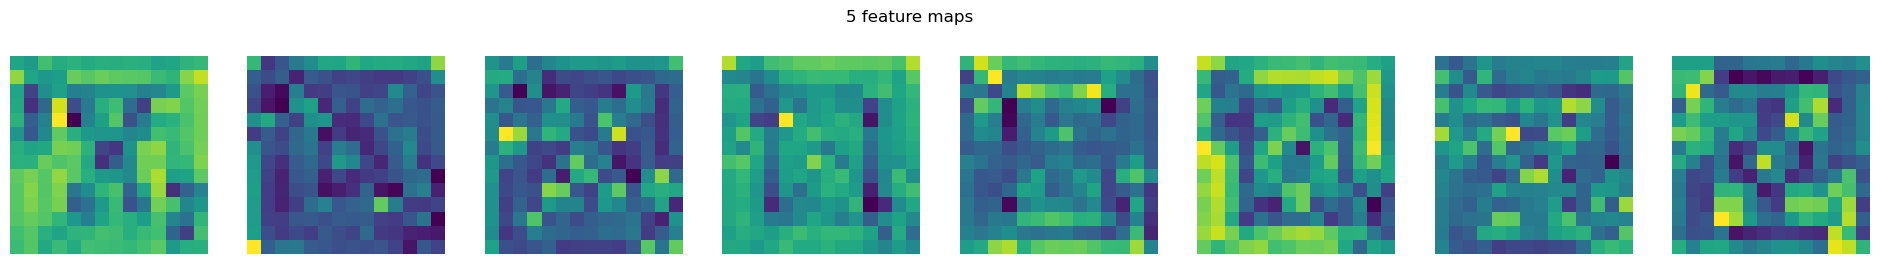

In [103]:
# Pick one example for each: 'king', 'queen', '8', '5'
# Make sure DATA_ROOT points at the rank-14 root
from pathlib import Path
import glob

DATA_ROOT = Path("data/cards_rank14")  # same root you used for training

def find_one_example(rank):
    """
    Look for an image for a given rank inside train/valid/test
    under data/cards_rank14.
    """
    for split in ["valid", "train", "test"]:  # prefer valid, then train, then test
        pattern = DATA_ROOT / split / rank / "*.*"   # <-- changed from *.png to *.*
        cands = sorted(glob.glob(str(pattern)))
        if cands:
            return cands[0]
    return None

examples = [
    find_one_example("king"),
    find_one_example("queen"),
    find_one_example("8"),
    find_one_example("5"),
]
examples = [e for e in examples if e is not None]
print("Examples:", examples)

def show_feature_maps(model, img_path, layer, n_show=8):
    model.eval()
    x = eval_tfms(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
    feats = []
    h = layer.register_forward_hook(lambda m, i, o: feats.append(o.detach().cpu()))
    with torch.no_grad():
        _ = model(x)
    h.remove()
    fmap = feats[0][0]  # C,H,W
    n_show = min(n_show, fmap.size(0))
    fig, axes = plt.subplots(1, n_show, figsize=(3 * n_show, 3))
    for i in range(n_show):
        axes[i].imshow(fmap[i], cmap="viridis")
        axes[i].axis("off")
    plt.suptitle(Path(img_path).parts[-2] + " feature maps")
    plt.show()

# Visualize from an early layer (edges/corners) and a deeper one
# Reuse the last fine-tuned model from the final fold above (ft_model)
for p in examples:
    show_feature_maps(ft_model, p, ft_model.layer1[0].conv1, n_show=8)
    show_feature_maps(ft_model, p, ft_model.layer3[0].conv1, n_show=8)
